# Self-Critic experiments

### Imports

In [1]:
%matplotlib inline
import sys
from time import time

import numpy as np
import torch
from torch import optim
from tqdm import tqdm as _tqdm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from envs.gridworld import GridworldEnv
from envs.windy_gridworld import WindyGridworldEnv
from models import PolicyNetwork, ValueNetwork
from utils import (compare_baselines_plot, get_running_time, plot_episodes_durations_losses, run_episode,
                   sample_greedy_return, select_action, set_seeds, smooth)

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

### Experimental settings

In [2]:
num_runs = 50
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape = [10, 10]
init_temperature = 1.1
stochasticity = 0.0

## REINFORCE w/ No Baseline

In [11]:
def compute_reinforce_loss_no_baseline(episode, discount_factor):
    discounted_return_list = []
    log_p_list = []
    G = 0
    
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        discounted_return_list.append(G)
        log_p_list.append(log_p)
    
    log_p_tensor = torch.stack(log_p_list)
    discounted_return_tensor = torch.FloatTensor(discounted_return_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_tensor)
    
    return loss

def run_episodes_no_baseline(model, env, num_episodes, discount_factor, learn_rate, init_temp = init_temperature): 
    optimizer = optim.Adam(model.parameters(), learn_rate)
    episode_durations = []
    losses = []
    
    for i in range(num_episodes):
        optimizer.zero_grad()
        
        episode = run_episode(env, model, i, init_temp, stochasticity)
        loss = compute_reinforce_loss_no_baseline(episode, discount_factor)
        
        loss.backward()
        optimizer.step()
          
        losses.append(loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(losses)

In [ ]:
def opt_nobaseline(param_dict):
    print(param_dict)
    env = GridworldEnv(shape=grid_shape)
    model = PolicyNetwork(hidden_dim = int(param_dict['policy_hiddens']))
    episode_durations, _ = run_episodes_no_baseline(model, 
                                                        env, 
                                                        num_episodes, 
                                                        param_dict['discount_factor'], 
                                                        param_dict['learn_rate'],
                                                        init_temp = param_dict['init_temp'])
    
    
    result = sum(episode_durations)/len(episode_durations)
    print("average number of episodes:", result)
    return result

space = {
    'discount_factor': hp.uniform('discount_factor', 0.000001, 0.9999999),
    'learn_rate': hp.loguniform('learn_rate', -5, -1),
    'policy_hiddens': hp.quniform('policy_hiddens', 16, 512, 2),
    'init_temp': hp.uniform('init_temp', 1, 2),
}

trials = Trials()
best = fmin(fn=opt_nobaseline, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print("best run:", best)

{'discount_factor': 0.743762143281344, 'init_temp': 1.518524159983604, 'learn_rate': 0.21535809066906939, 'policy_hiddens': 366.0}
average number of episodes:                          
44.828                                               
{'discount_factor': 0.6896120343705908, 'init_temp': 1.9927927137468922, 'learn_rate': 0.08562769924654816, 'policy_hiddens': 146.0}
average number of episodes:                                       
45.178                                                            
{'discount_factor': 0.7496853099675018, 'init_temp': 1.8618483801334866, 'learn_rate': 0.013995403881352236, 'policy_hiddens': 202.0}
average number of episodes:                                       
44.081                                                            
{'discount_factor': 0.37986412489364724, 'init_temp': 1.3415327261464192, 'learn_rate': 0.03728278135165172, 'policy_hiddens': 76.0}
  3%|▎         | 3/100 [00:41<22:54, 14.17s/it, best loss: 44.081]

In [4]:
env = GridworldEnv(shape=grid_shape)

no_episode_durations = []
no_policy_losses = []


for i in range(num_runs):
    start_time = time()

    model = PolicyNetwork()
    seed = 40 + i
    set_seeds(env, seed)

    episode_durations, policy_losses = run_episodes_no_baseline(model, 
                                                                env, 
                                                                num_episodes, 
                                                                discount_factor, 
                                                                learn_rate)
    
    no_episode_durations.append(episode_durations)
    no_policy_losses.append(policy_losses)
    
    del model
    
    end_time = time()
    h, m, s = get_running_time(end_time - start_time)
    
    print(f'Done with run {i+1}/{num_runs} in {f"{h} hours, " if h else ""}{f"{m} minutes and " if m else ""}{s} seconds')

Done with run 1/50 in 6 seconds
Done with run 2/50 in 10 seconds
Done with run 3/50 in 5 seconds
Done with run 4/50 in 6 seconds
Done with run 5/50 in 4 seconds
Done with run 6/50 in 17 seconds
Done with run 7/50 in 18 seconds
Done with run 8/50 in 17 seconds
Done with run 9/50 in 5 seconds
Done with run 10/50 in 17 seconds
Done with run 11/50 in 17 seconds
Done with run 12/50 in 15 seconds
Done with run 13/50 in 18 seconds
Done with run 14/50 in 9 seconds
Done with run 15/50 in 9 seconds
Done with run 16/50 in 6 seconds
Done with run 17/50 in 8 seconds
Done with run 18/50 in 7 seconds
Done with run 19/50 in 12 seconds
Done with run 20/50 in 5 seconds
Done with run 21/50 in 8 seconds
Done with run 22/50 in 6 seconds
Done with run 23/50 in 6 seconds
Done with run 24/50 in 18 seconds
Done with run 25/50 in 6 seconds
Done with run 26/50 in 17 seconds
Done with run 27/50 in 6 seconds
Done with run 28/50 in 5 seconds
Done with run 29/50 in 4 seconds
Done with run 30/50 in 5 seconds
Done wit

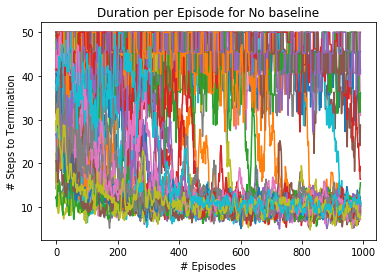

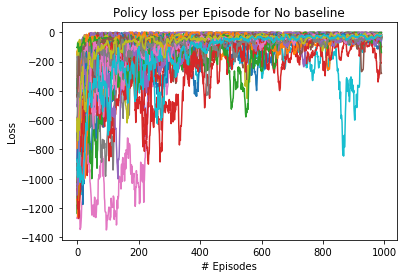

In [5]:
plot_episodes_durations_losses(no_episode_durations, no_policy_losses, None, 'No baseline')

## REINFORCE w/ Learned Baseline (Value Network)

In [8]:
def compute_reinforce_loss_with_learned_baseline(value_model, episode, discount_factor, env):    
    discounted_return_list = []
    log_p_list = []
    G = 0
    
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        state = np.unravel_index(s, env.shape)
        baseline = value_model(torch.FloatTensor(state))
        
        discounted_return_list.append(G - baseline)
        log_p_list.append(log_p)
        
    log_p_tensor = torch.stack(log_p_list)
    discounted_return_tensor = torch.FloatTensor(discounted_return_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_tensor)
    
    return loss

def compute_value_loss(value_model, episode, discount_factor, env):
    returns = []
    value_estimates = []
    G = 0
    
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        returns.append(G)
        
        state = np.unravel_index(s, env.shape)
        value_estimates.append(value_model(torch.FloatTensor(state)))

    value_estimates_tensor = torch.stack(value_estimates) 
    returns_tensor = torch.FloatTensor(returns)
    
    loss = torch.sum(torch.abs(returns_tensor - value_estimates_tensor))
    
    return loss

def run_episodes_with_learned_baseline(policy_model, value_model, env, num_episodes, discount_factor, 
                                       learn_rate_policy, learn_rate_value):
    policy_optimizer = optim.Adam(policy_model.parameters(), learn_rate_policy)
    value_optimizer = optim.Adam(value_model.parameters(), learn_rate_value)
    
    episode_durations = []
    value_losses = []
    reinforce_losses = []
    
    for i in range(num_episodes):    
        policy_optimizer.zero_grad()
        value_optimizer.zero_grad()
        
        episode = run_episode(env, policy_model, i, init_temperature, stochasticity)
        reinforce_loss = compute_reinforce_loss_with_learned_baseline(value_model, episode, discount_factor, env)
        value_loss = compute_value_loss(value_model, episode, discount_factor, env)
        
        reinforce_loss.backward()
        policy_optimizer.step()
        
        value_loss.backward()
        value_optimizer.step()
            
        episode_durations.append(len(episode))
        reinforce_losses.append(reinforce_loss.detach().numpy())
        value_losses.append(value_loss.detach().numpy())
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(reinforce_losses), np.asanyarray(value_losses)

In [ ]:
def opt_learned_baseline(param_dict):
    print(param_dict)
    env = GridworldEnv(shape=grid_shape)
    
    
    policy_model = PolicyNetwork(hidden_dim = int(param_dict['policy_hiddens']))
    value_model = ValueNetwork(hidden_dim = int(param_dict['value_hiddens']))

    episode_durations, _, _ = run_episodes_with_learned_baseline(policy_model,
                                                                 value_model,
                                                                 env,
                                                                 num_episodes,
                                                                 param_dict['discount_factor'], 
                                                                 param_dict['learn_rate_policy'],
                                                                 param_dict['learn_rate_value'])
    
    result = sum(episode_durations)/len(episode_durations)
    print("average number of episodes:", result)
    return result

space = {
    'discount_factor': hp.uniform('discount_factor', 0.000001, 0.9999999),
    'learn_rate': hp.loguniform('learn_rate', -5, -1),
    'policy_hiddens': hp.quniform('policy_hiddens', 16, 512, 2),
    'value_hiddens': hp.quniform('policy_hiddens', 16, 512, 2),
}

trials = Trials()
best = fmin(fn=opt_nobaseline, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

In [9]:
env = GridworldEnv(shape=grid_shape)

learned_baseline_episode_durations = []
learned_baseline_policy_losses = []
learned_baseline_value_losses = []

for i in range(num_runs):
    start_time = time()
    
    policy_model = PolicyNetwork()
    value_model = ValueNetwork()
    seed = 40 + i
    set_seeds(env, seed)

    episode_durations, policy_losses, value_losses = run_episodes_with_learned_baseline(policy_model,
                                                                                        value_model,
                                                                                        env,
                                                                                        num_episodes,
                                                                                        discount_factor,
                                                                                        learn_rate,
                                                                                        learn_rate)
    
    learned_baseline_episode_durations.append(episode_durations)
    learned_baseline_policy_losses.append(policy_losses)
    learned_baseline_value_losses.append(value_losses)
    
    del policy_model
    del value_model
    
    end_time = time()
    h, m, s = get_running_time(end_time - start_time)
    
    print(f'Done with run {i+1}/{num_runs} in {f"{h} hours, " if h else ""}{f"{m} minutes and " if m else ""}{s} seconds')

Done with run 1/50 in 13 seconds
Done with run 2/50 in 9 seconds
Done with run 3/50 in 7 seconds
Done with run 4/50 in 13 seconds
Done with run 5/50 in 9 seconds
Done with run 6/50 in 10 seconds
Done with run 7/50 in 11 seconds
Done with run 8/50 in 13 seconds
Done with run 9/50 in 10 seconds
Done with run 10/50 in 11 seconds
Done with run 11/50 in 12 seconds
Done with run 12/50 in 13 seconds
Done with run 13/50 in 9 seconds
Done with run 14/50 in 27 seconds
Done with run 15/50 in 17 seconds
Done with run 16/50 in 8 seconds
Done with run 17/50 in 10 seconds
Done with run 18/50 in 13 seconds
Done with run 19/50 in 27 seconds
Done with run 20/50 in 10 seconds
Done with run 21/50 in 11 seconds
Done with run 22/50 in 27 seconds
Done with run 23/50 in 10 seconds
Done with run 24/50 in 11 seconds
Done with run 25/50 in 12 seconds
Done with run 26/50 in 15 seconds
Done with run 27/50 in 11 seconds
Done with run 28/50 in 11 seconds
Done with run 29/50 in 24 seconds
Done with run 30/50 in 26 se

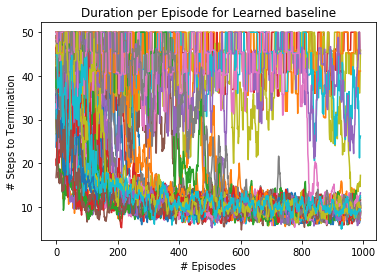

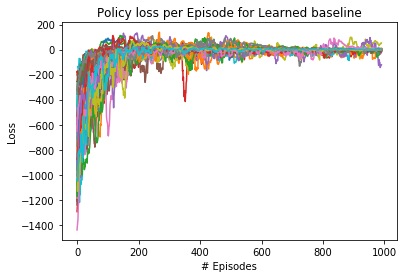

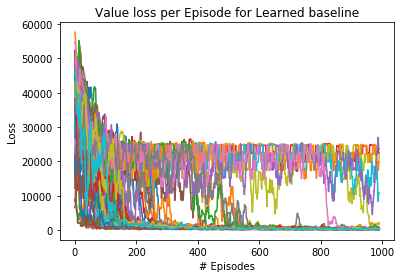

In [10]:
plot_episodes_durations_losses(learned_baseline_episode_durations, learned_baseline_policy_losses, learned_baseline_value_losses, 'Learned baseline')

## REINFORCE w/ Self-Critic Baseline

In [11]:
def compute_reinforce_loss_with_SC_baseline(model, episode, discount_factor, env):    
    discounted_return_list = []
    log_p_list = []
    G = 0
    
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        baseline = sample_greedy_return(model, env, discount_factor, s)
        
        discounted_return_list.append(G - baseline)
        log_p_list.append(log_p)
        
    log_p_tensor = torch.stack(log_p_list)
    discounted_return_tensor = torch.FloatTensor(discounted_return_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_tensor)
    
    return loss


def run_episodes_with_SC_baseline(model, env, num_episodes, discount_factor, learn_rate):
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    policy_losses = []
    
    for i in range(num_episodes):
        optimizer.zero_grad()
        
        episode = run_episode(env, model, i, init_temperature, stochasticity)
        loss = compute_reinforce_loss_with_SC_baseline(model, episode, discount_factor, env)
        
        loss.backward()
        optimizer.step()
        
        episode_durations.append(len(episode))
        policy_losses.append(loss.detach().numpy())
        
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(policy_losses)

In [ ]:
def opt_SC_baseline(param_dict):
    print(param_dict)
    env = GridworldEnv(shape=grid_shape)
    
    
    policy_model = PolicyNetwork(hidden_dim = int(param_dict['policy_hiddens']))

    episode_durations, _, _ = run_episodes_with_SC_baseline(model,
                                                            env,
                                                            num_episodes,
                                                            param_dict['discount_factor'], 
                                                            param_dict['learn_rate_policy'])    
    
    result = sum(episode_durations)/len(episode_durations)
    print("average number of episodes:", result)
    return result

space = {
    'discount_factor': hp.uniform('discount_factor', 0.000001, 0.9999999),
    'learn_rate': hp.loguniform('learn_rate', -5, -1),
    'policy_hiddens': hp.quniform('policy_hiddens', 16, 512, 2),
}

trials = Trials()
best = fmin(fn=opt_nobaseline, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

In [12]:
env = GridworldEnv(shape=grid_shape)

sc_baseline_episode_durations = []
sc_baseline_policy_losses = []

for i in range(num_runs):
    start_time = time()
    
    model = PolicyNetwork()
    seed = 40 + i
    set_seeds(env, seed)

    episode_durations, policy_losses = run_episodes_with_SC_baseline(model, 
                                                                     env, 
                                                                     num_episodes, 
                                                                     discount_factor, 
                                                                     learn_rate)
    
    sc_baseline_episode_durations.append(episode_durations)
    sc_baseline_policy_losses.append(policy_losses)
    
    del model
    
    end_time = time()
    h, m, s = get_running_time(end_time - start_time)
    
    print(f'Done with run {i+1}/{num_runs} in {f"{h} hours, " if h else ""}{f"{m} minutes and " if m else ""}{s} seconds')

Done with run 1/50 in 38 seconds
Done with run 2/50 in 19 seconds
Done with run 3/50 in 18 seconds
Done with run 4/50 in 15 seconds
Done with run 5/50 in 3 minutes and 36 seconds
Done with run 6/50 in 50 seconds
Done with run 7/50 in 34 seconds
Done with run 8/50 in 25 seconds
Done with run 9/50 in 16 seconds
Done with run 10/50 in 3 minutes and 4 seconds
Done with run 11/50 in 19 seconds
Done with run 12/50 in 22 seconds
Done with run 13/50 in 1 minutes and 1 seconds
Done with run 14/50 in 22 seconds
Done with run 15/50 in 21 seconds
Done with run 16/50 in 27 seconds
Done with run 17/50 in 10 seconds
Done with run 18/50 in 23 seconds
Done with run 19/50 in 12 seconds
Done with run 20/50 in 42 seconds
Done with run 21/50 in 1 minutes and 11 seconds
Done with run 22/50 in 11 seconds
Done with run 23/50 in 3 minutes and 15 seconds
Done with run 24/50 in 51 seconds
Done with run 25/50 in 14 seconds
Done with run 26/50 in 48 seconds
Done with run 27/50 in 58 seconds
Done with run 28/50 in 

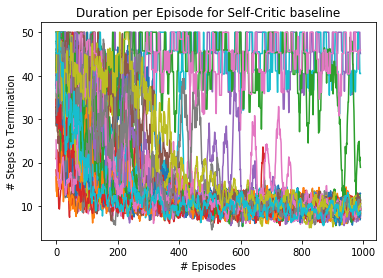

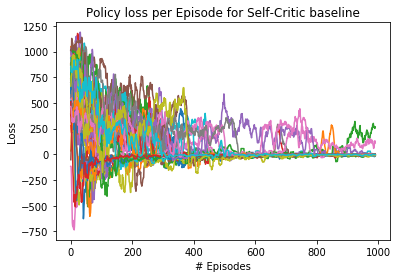

In [13]:
plot_episodes_durations_losses(sc_baseline_episode_durations, sc_baseline_policy_losses, None, 'Self-Critic baseline')

## Comparison of baselines

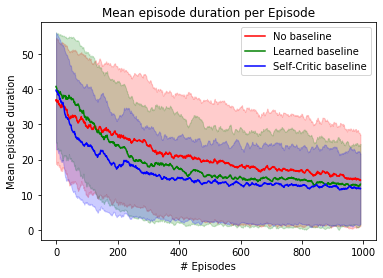

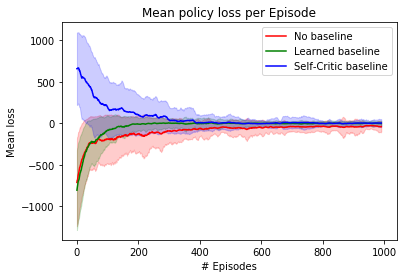

In [14]:
baselines_dict = {
    'No baseline': {
        'episode_durations': no_episode_durations,
        'policy_losses': no_policy_losses,
        'color': 'red'
    }, 'Learned baseline': {
        'episode_durations': learned_baseline_episode_durations,
        'policy_losses': learned_baseline_policy_losses,
        'color': 'green'
    }, 'Self-Critic baseline': {
        'episode_durations': sc_baseline_episode_durations,
        'policy_losses': sc_baseline_policy_losses,
        'color': 'blue'
    }
}

compare_baselines_plot(baselines_dict)